<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>

Привет Александр! Меня зовут Марат, и я буду твоим ревьюером. Спешу сообщить что все ключевые этапы в работе выполнены,  с задачей тебе удалось справиться. По поводу обращения - в IT сфере принято общаться на «ты» :) Но, если привычней на «вы», дай знать. Как ревьюера моя задача помочь тебе в развитии, дав хорошие советы. Я внимательно посмотрю твой код, ознакомлюсь с твоими выводами и оставлю комментарии. Где то могу предложить небольшие исправление в коде, но ненавязчиво. Где потребуются уточнения, я оставлю много наводящих вопросов. Они помогут тебя с поиском верного решения.

Все мои комментарии размечены по цветам, для лучшего восприятия. 
    
<div class="alert alert-success">Зеленым цветом и словом «Успех» отмечены особо удачные и элегантные решения, которыми ты можешь гордиться. </div>
        
<div class="alert alert-warning">Желтым и значком словом «Совет», помечены решения у которых есть альтернативные решения, более оптимальные. Ты можешь найти их сразу и доработать проект, или отложить это на потом, для будущих проектах. Проект будет принят и без их доработки. </div>
        
<div class="alert alert-danger"> Красным цветом и значком словом «Ошибка» помечу твои решения, на которые стоит обратить внимание прежде всего. После их доработки проект будет принят. </div>
        
Залог успеха - работа сообща, взаимное уважение и работа в диалоге. Поэтому, помечай свои ответные комментарии на мои реплики заметным цветом или курсивом, так мне будет легче их отслеживать. Пожалуйста, не изменяй и не удаляй мои комментарии. Все это поможет выполнить повторную проверку быстрей.

</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>

Привет! Договорились, оставлю комментарии на свои изменения таким цветом
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Привет Александр! Принято




</div>


# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Цель исследования**
  
Создать систему рекомендаций тарифов на основе данных о использовании мобильной сети и мобильного трафика пользователями

**Ход исследования**

 - Сформируем обучающую, валидационную и тестовую выборки
 - Изучим точность нескольких моделей: `дерева решений`, `случайного леса` и `логистической регрессии`
 - Проверим наиболее точную модель на тестовой выборке
 - проверим наиболее точную модель в тесте на адекватность

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Вступление в работу очень важно, так человек, который смотрит твой проект (и на работе в том числе) будет сразу введен в курс дела.





</div>

## Откройте и изучите файл

In [1]:
!pip install tqdm -U

     |████████████████████████████████| 77 kB 990 kB/s eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.61.2
    Uninstalling tqdm-4.61.2:
      Successfully uninstalled tqdm-4.61.2


Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
from tqdm import tqdm

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Собираем все импорты в верхней части, чтобы легче было ориентироваться и добавлять новые по необходимости. 


<div class="alert alert-warning">

Совет:     
    
    


- кстати есть рекомендации PEP-8 при написании кода, в том числе и для импортов. Если интересно можешь почитать [тут](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html), в будущем пригодится ) 
</div>
</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>

Спасибо, буду стараться весь код соблюдать по стандартам. А можешь подсказать, как правильнее оформить импорт? Вроде каждый на отдельной строке и импортирую только то, что используется
</div>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:

    
Пока исправлять особо нечего, это на будущее.  Будущем могут быть такие ошибки    
    
Вместо
    

    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import GridSearchCV
    

Пишем в одну строку через запятую    

    
    from sklearn.model_selection import cross_val_score,  train_test_split, ...
    
    
И я не знаю специально ты или случайно, но ты правильно поставил в самый низ 
    
    
    
    from tqdm import tqdm
    
    
, потому что это сторонняя библиотека
    
    

Импортируем данные

In [2]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')

Познакомимся с датасетом

На первый взгляд, нет отсутсвующих значений

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Аномально больших или множество нулевых значений в нашем датасете нет

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Посмотрим на распределение целевого признака

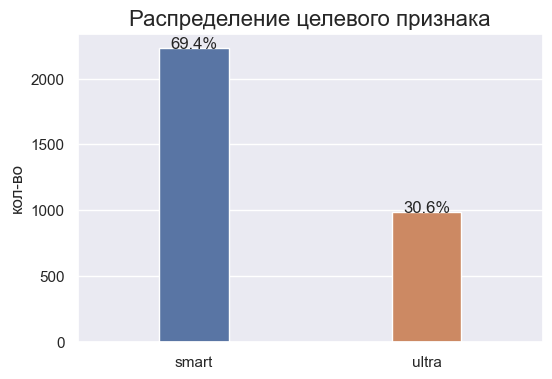

In [18]:
sns.set_theme()
percentage = [len(df[df['is_ultra'] == 0]) / df.shape[0],
              len(df[df['is_ultra'] == 1]) / df.shape[0]]
plt.figure(figsize=(6, 4))
ax = sns.barplot(y=df['is_ultra'].value_counts(), 
                 x=['smart', 'ultra'], 
                 width=0.3)
plt.title('Распределение целевого признака', fontsize=16)
plt.ylabel('кол-во')

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.1%}'.format(percentage[i]), (x, y), ha='center')
plt.show()

Посмотрим на корреляцию признаков

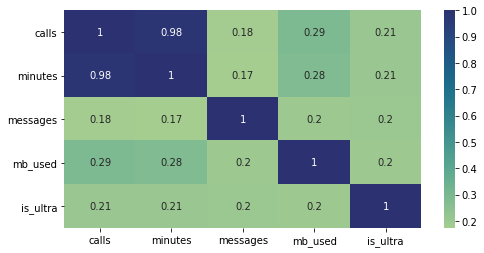

In [5]:
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(), annot=True, cmap='crest')
plt.show()

В нашем датасете целевой признак распределен не равномерно, что стоить учесть при обучении модели.  
Также, есть зависимость между признаками `calls`(кол-во звонков) и `minutes`(кол-во потраченных минут на звонки)

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:
    
Мне пришлось подправить твой код чтобы запустилось. Для некоторых особо строгих ревьюеров это основание завернуть работу без проверки, так что будь внимательней в следующий раз )
    
Совет - используй конструкцию try except:    
  
    try:

        df = pd.read_csv('C:/your_project/users_behavior.csv')
    except:

        df = pd.read_csv('/datasets/users_behavior.csv')
   
</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>

Спасибо, что исправил и проверил дальше) И за удобную конструкцию, чтобы не менять путь до датасета каждый раз, когда буду отправлять проект на ревью
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

👍 Данные изучены.



<div class="alert alert-warning">



Совет: 




- Можно еще отдельно проверить датасет на сбалансированность классов в таргете. Это помогло бы решить бонусное задание сразу (Только не надо балансировать данные, это тема следующего проекта).




- Можно посмотреть корреляцию признаков. Знаешь что такое мультиколлинеарность, какие два типа проблем возникает, для каких моделей и какие варианты решения?




</div>
</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>

Добавил оба пункта. Про мультиколлинеарность очень полезным оказался комментарий - я прочитал статьи, на ютубе ролики посмотрел, много нового узнал. А до этого даже не задумывался о том, что корреляция между признаками может мешать обучению. Да и в принципе, стало очень интересно, как проблемы или особенности в данных могут влиять на обучение и как с этим справиться, теперь читаю на эти темы статьи,  пусть и не все термины еще понимаю)
</div>


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>


Совет 🤔:



- Мультиколлинеарность


    
    
    

Не знаю вычитал ты это или нет, но очень часто мультикалинеарность не представляет собой особую проблему.  Как видишь у нас есть мультиколлинеарность, и кажется что можно один из признаков убрать, но на самом деле не всё так плохо
    


- Первый момент: мультиколлинеарность проблема линейных моделей - могут переобучаться.... теоретически. Но в логистической, и в линейной регрессиях реализована регуляризация, которая решает проблему мультиколлинеарности признаков. "Деревянные" модели (RF, DT) устойчивы к мультиколлинеарности, а кластеризация тоже почти не зависит от линейных зависимостей. Получается, избавляться от мультиколлинеарности чтобы не переобучаться не обязательно )) 
    
    
- Второй момент: интерпретируемость линейной модели (мы по коеффициентам судим как признаки влияют на таргет), тут  мультиколлинеарность надо убирать.


Так что получается что в нашем случае убирать мультиколлинеарность имеет смысл только если мы захотим посмотреть как конкретно признаки влияют на Таргет

   

## Разбейте данные на выборки

Разобьем наш датасет на выборку для обучения и теста. Используем параметр *stratify*, чтобы в выборках сохранилось изначальное распределение таргета

In [19]:
X = df.drop(['is_ultra'], axis=1)
y = df['is_ultra']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345, stratify=y)

print('Train size: ', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size:  2571
Test size:  643


И проверим разбиение на датасетах с таргет признаками(для фич оно будет такое же)

In [7]:
print('Размер тренировочного датасета', '{:.2%}'.format(target_train.shape[0] / target.shape[0]))
print('Размер тестового датасета', '{:.2%}'.format(target_test.shape[0] / target.shape[0]))
print('Размер валидирующего датасета', '{:.2%}'.format(target_valid.shape[0] / target.shape[0]))

Размер тренировочного датасета 59.99%
Размер тестового датасета 20.01%
Размер валидирующего датасета 20.01%


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Все правильно!



<div class="alert alert-warning">



Совет: 


- Обрати внимание на аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах.  Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым. [Почитать](https://pythonru.com/baza-znanij/sklearn-train-test-split) можно тут


- После разбиения лучше перестраховаться и использовать .shape, для контроля за корректностью разбиения
</div>
</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>

Еще одна вещь о которой даже не подумал, теперь выборки будут подобные друг другу
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



👍




</div>


## Исследуйте модели

### Дерево решений

Первая модель для исследования - дерево решений. Попробуем глубину дерева от 1 до 10 и выберем самую удачную

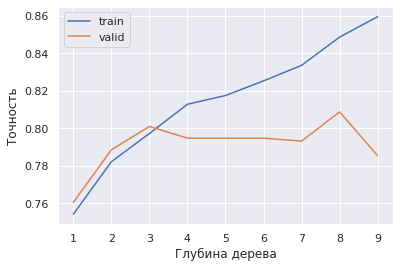

Оптимальная глубина: 8
Лучшая точность: 0.8087091757387247


In [8]:
def decision_tree(return_model=False):
    accuracy_train = []
    accuracy_valid = []
    best_accuracy = 0
    best_depth = 0

    for depth in range(1, 10):
        model = DecisionTreeClassifier(max_depth=depth, random_state=123)
        model.fit(features_train, target_train)

        answers_train = model.predict(features_train)
        answers_valid = model.predict(features_valid)

        accuracy_train.append(accuracy_score(target_train, answers_train))
        accuracy_valid.append(accuracy_score(target_valid, answers_valid))

        if accuracy_valid[depth - 1] > best_accuracy:
            best_accuracy = accuracy_valid[depth - 1]
            best_depth = depth
            best_model = model

    sns.set()
    xaxis = range(1, len(accuracy_train)+1)
    sns.lineplot(x=xaxis, y=accuracy_train, label='train')
    sns.lineplot(x=xaxis, y=accuracy_valid, label='valid')
    plt.xlabel('Глубина дерева')
    plt.ylabel('Точность')
    plt.show()
    print('Оптимальная глубина:', best_depth)
    print('Лучшая точность:', best_accuracy)

decision_tree()

Видно, что модель начинает переобучаться, если задать слишком высокий гиперпараметр глубины

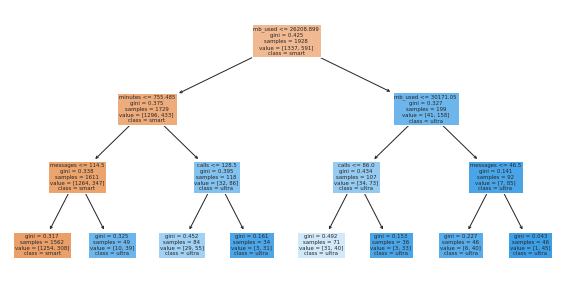

In [9]:
model = DecisionTreeClassifier(max_depth=3, random_state=123)
model.fit(features_train, target_train)
plt.figure(figsize=(10, 5))
plot_tree(model, feature_names=['calls', 'minutes', 'messages', 'mb_used'], class_names=['smart', 'ultra'], filled=True)
plt.show()

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:
 
Работа выполнена в соответствии с критериями: 



 - модель обучена на обучающем наборе
 - получена оценка качества на валидационном наборе
 - перебор гиперпараметров осуществляется в цикле


Отличный график, и верный вывод



<div class="alert alert-warning">


Совет: 


- tree_plot можно построить, с max_depth равной 3 или 4 (глубже уже будет громоздко) - глянуть как DT сплиты делает, будет понимание как модель принимает решения: какие признаки  использует, на каких значениях делает разбиение вправо - влево 




</div>
</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>

Как человеку, любящему все визуализировать, мне нравится возможно увидеть дерево в таком виде. И видно сразу, как повлиял баланс классов. Как я понял, в обозначениях узла value =[] это число обьектов, отнесенных вправо/влево. А почему тогда значение samples у дочерних узлов отличается? Или samples это не количество обьектов, которые узлу надо распределить?
</div>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:



1337+597 = Число примеров тренировочной выборке.  Как-то так должно быть 


### Лес деревьев

Следующая модель - лес деревьев. Его обучение и перебор количества деревьев займет больше времени, но и точность ожидается выше

100%|██████████| 55/55 [00:34<00:00,  1.58it/s]


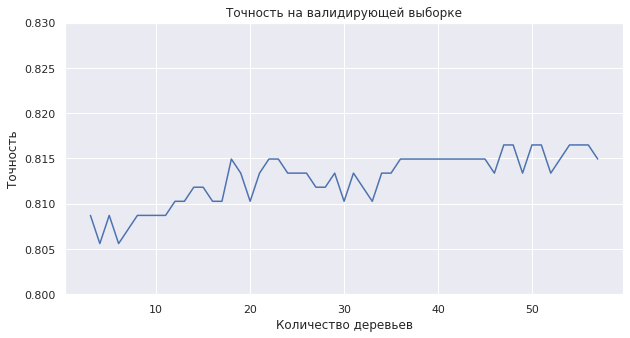

Оптимальное количество деревьев: 47 c глубиной 8
Лучшая точность: 0.8164852255054432


In [10]:
def random_forest():
    accuracy = []
    best_accuracy = 0
    best_est = 0
    best_depth = 0

    for est in tqdm(range(3, 58)):
        best_accuracy_tmp = 0
        best_depth_tmp = 0
        
        # перебираем для каждого n_estimators глубину деревьев и выбираем лучшую
        for depth in range(2, 10):
            model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=123)
            model.fit(features_train, target_train)
        
            answers = model.predict(features_valid)
            accuracy_tmp = (accuracy_score(target_valid, answers))

            if accuracy_tmp > best_accuracy_tmp:
                best_accuracy_tmp = accuracy_tmp
                best_depth_tmp = depth
                
        accuracy.append(best_accuracy_tmp)
        if best_accuracy_tmp > best_accuracy:
            best_accuracy = best_accuracy_tmp
            best_est = est
            best_depth = best_depth_tmp

    sns.set()
    plt.figure(figsize=(10, 5))
    xaxis = range(3, len(accuracy)+3)
    sns.lineplot(x=xaxis, y=accuracy)
    plt.ylim(0.8, 0.83)
    plt.title('Точность на валидирующей выборке')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Точность')
    plt.show()
    print('Оптимальное количество деревьев:', best_est, 'c глубиной', best_depth)
    print('Лучшая точность:', best_accuracy)

random_forest()

Случайный лес показывает высокую точность уже при небольшом количестве деревьев. Стоит ли использовать больше, например 18 деревьев, ради прироста точности на сотую часть? Тут нужно оценивать уже затраты модели и ожидаемую прибыль от предсказаний модели

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:



- Александр, можно было сделать похитрее, RF одна из лучших моделей в классическом machine-learning, поэтому можно было добавить перебор 2 гиперпараметров в двойном цикле, в результата метрика качества вырастет. 
 


- Когда что то долго крутиться, можно использовать  %%time - ставишь на самый вверх ячейки с кодом, время выполнения которого хочешь замерить, может не знаешь.  Быстрее не станет, но все будут видеть стоит ли ждать не отходя от ПК или можно сходить чаек поставить )) 
    
    Или tqdm, это ещё лучше, потому что он показывает интерактивно, на каком этапе расчетов мы находимся

    
    from tqdm import tqdm


    for n_estimators in tqdm(range(3,58)):

        ..........



(дальше мы будем уходить от неэффективных в питоне циклов к apply.  Там тоже есть аналог прогресс-баров:  .progress_apply)
    
И будет красиво )   
 



- Видишь разницу, и можешь объяснить разницу между поведением метрики на валидации у дерева решений и случайного леса 
</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>
    
Прогресс-бар вообще крутой, появилось желание его почти везде теперь использовать) Пробовал еще менять критерий разделения на 'entropy' - результат почти такой же
</div>

### Логистическая регрессия

Модель - логистическая регрессия. У нее попробуем поменять гиперпараметр итераций обучения от 100 до 1000 с шагом в 100

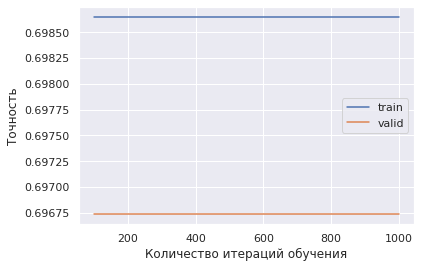

Оптимальное количество итераций обучения: 100
Лучшая точность: 0.6967340590979783


In [11]:
def logistic_regression():
    accuracy_train = []
    accuracy_valid = []
    best_accuracy = 0
    best_iter = 0

    for iterations in range(100, 1001, 100):
        model = LogisticRegression(max_iter=iterations, random_state=123)
        model.fit(features_train, target_train)

        answers_train = model.predict(features_train)
        answers_valid = model.predict(features_valid)

        accuracy_train.append(accuracy_score(target_train, answers_train))
        accuracy_valid.append(accuracy_score(target_valid, answers_valid))

        if accuracy_valid[iterations//100 - 1] > best_accuracy:
            best_accuracy = accuracy_valid[iterations//100 - 1]
            best_iter = iterations

    sns.set()
    xaxis = range(100, len(accuracy_train)*100+1, 100)
    sns.lineplot(x=xaxis, y=accuracy_train, label='train')
    sns.lineplot(x=xaxis, y=accuracy_valid, label='valid')
    plt.xlabel('Количество итераций обучения')
    plt.ylabel('Точность')
    plt.show()
    print('Оптимальное количество итераций обучения:', best_iter)
    print('Лучшая точность:', best_accuracy)

logistic_regression()

Гиперпараметр никак не повлиял на точность обученной модели

### Итог
---
По итогам, наиболее точной в предсказаниях оказалась модель случайного леса. Ее мы дальше и проверим на тестовой выборке, а также на адекватность


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Все верно, RF лучший. 


<div class="alert alert-warning">


Совет: 

Если есть желание можешь ответить на вопросики ))    



- Как назвать ситуацию, когда на валидации при увеличении глубины дерева (модель DT), метрика качества стала снижаться? Как по твоему в это же время вела себя эта же метрика на train?


- Насколько знаю вы еще под капот моделям не заглядывали, но может знаешь почему обычно RF показывает более высокие результаты из выбранных?


- Мы решаем задачу классификации (а еще есть задача регрессии), а в названии модели с помощью которой мы решаем задачу "классификации" (Логистическая регрессия) есть слово "регрессия".  Нет ли тут парадокса? )
    

- Почему логистическая регрессия показывать на много более худшие результаты?  

</div>
</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>
    
 - Это переобучение, модель дерева становиться настолько большой, что начинает не предсказывать зависимости между фичами и таргетом, а просто включает в себя каждый вариант фичи/таргет
    
 - Насколько я понял, в RF для каждого дерева при обучении своя подвыборка, так что, даже если одно дерево переобучиться, то остальные нет. А решение принимается голосованием всех деревьев и шанс, что большинство окажется переобученым низкий
    
 - Ну, регрессия - это восстановление зависимости, а добавляя слово логистическая, модель предсказывает не значение точки, вероятность отнести ее к какому-либо из классов
    
 - Думаю, у логистической регрессии такие результаты из-за корреляции в признаках, а еще значения признаков не нормализованы
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>


Успех:


Дополню чуть

1. Верно
    
    
2. Да, в RF обучается несколько деревьев, а решение принимается путем голосования. Каждое дерево в RF учится на своем датасете (используется техника бутстрап), таким образом достигается "независимость" этих самых деревьев, в итоге ошибка разброса снижается.

    
3. "Регрессия", потому что внутри нее скалярное произведение (как и в линейной регрессии), дающее на выходе вещественное число (от + бесконечности до - бесконечности), на это число вешают сигмойду, логарифм и получают значение от 0 до 1 (вероятность класса).   
    
    
4. Логистическая регрессия плоха (и хороша с другой стороны) тем что это линейный классификатор: обьекты на классы разделяем гиперплоскостью (прямой если на плоскости), а в данном датасете видимо более сложные, нелинейные связи между признаками и таргетом.   А RF с DT с этим справляются. На других данных  LR могла оказаться лучше, например потому что RF не может экстраполировать.


</div>

## Проверьте модель на тестовой выборке

Выборку для валидации теперь можно объединить с обучающей

In [16]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

best_model = RandomForestClassifier(n_estimators=47, max_depth=8, random_state=123)
best_model.fit(features_train, target_train)
answers_test = best_model.predict(features_test)
print('Точность на тестовой выборке', accuracy_score(target_test, answers_test))

Точность на тестовой выборке 0.8211508553654744


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Ошибка ❌:




Может после стратификации но теперь у тебя лучшие гиперпараметры такие
    
    Оптимальное количество деревьев: 47 c глубиной 8
</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студентаV2</b></font>
    
Действительно, забыл изменить. Исправил 
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV3</b></font>



Успех 👍:



👍




</div>


Точность оказалась на уровне валидирующей выборки, что ожидаемо

---
Посмотрим еще на разные метрики модели

Матрица ошибок

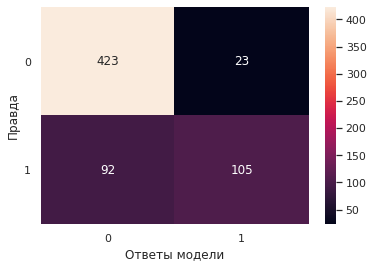

In [17]:
conf_matrix = confusion_matrix(target_test, answers_test)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Ответы модели')
plt.ylabel('Правда')
plt.yticks(rotation=0);

Precision, recall и F1

In [18]:
report = classification_report(target_test, answers_test, target_names=['Smart', 'Ultra'])
print(report)

              precision    recall  f1-score   support

       Smart       0.82      0.95      0.88       446
       Ultra       0.82      0.53      0.65       197

    accuracy                           0.82       643
   macro avg       0.82      0.74      0.76       643
weighted avg       0.82      0.82      0.81       643



Наша модель точнее рекомендует тариф Smart, сказывается дизбаланс классов в тренировочном датасете. Наша модель почти точно найдет людей, которым подойдет тариф Smart, а вот тех, кому подойдет Ultra - только 53%. Я бы вернулся к заказчику с уточнением, какие метрики для него важнее. И получается, что метрику accuracy не совсем релевантно использовать для оценки пригодности бизнес-задаче


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


- Все верно, логика моделирования не нарушена, тут тестируем только лучшую модель (или парочку, если метрики были близки) отобранную на валидации. 

- Если студент получил на тесте accuraсy  выше 0,78, это считается отличным результатом. Ты подбираешь лучшую комбинацию не по одному гиперпараметру и вот он результат!



<div class="alert alert-warning">

Вопросики и совет:




- Как попробовать улучшить результат, не мучаясь с кодом?! Смотри - мы сформировали train выборку на которой обучаем модель, а валидационную используем для поиска лучших значений гиперпараметров. Оке, нашли их. Так почему бы теперь модель с выбранными гиперпараметрами не обучить на тренировочной + валидационной выборке (только не нужно делать новые сплиты, используй pd.concat(), к примеру)?! Чем больше данных, тем лучше модель может обучиться. И эту дообученную модель проверим на тесте. Гаранитий что станет лучше нет, но ML это постоянные эксперименты.  
    
    
- А можешь предложить как нам использовать полученный результат в бизнесе? Как нам на этих прогнозах сделать деньги? 




- Александр, в качестве бонуса можешь вывести еще несколько метрик своей модели - precision, recall, F1 и confussion matrix) Все есть в sklearn)
</div>
</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>
    
 - Сделал
    
 - Насколько я понял, в RF для каждого дерева при обучении своя подвыборка, так что, даже если одно дерево переобучиться, то остальные нет. А решение принимается голосованием всех деревьев и шанс, что большинство окажется переобученым низкий
    
 - Например, если модель верно предскажет тариф, клиент на него перейдет, а с нового тарифа компания будет получать больше прибыли. Или, при верной рекомендации тарифа клиент не перейдет в другую компания, то есть, снижение оттока(хотя, возможна и ситуация, при которой неверно предсказаный тариф подтолкнет клиента уйти)
    
 - Узнал огромный пласт информации про метрики, теперь мне моя accuracy кажется почти бесполезной) 
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Успех:
    
- Довольный клиент это к деньгам, и рост конверсия тоже прибыли ) Я вижу практическое применение прогнозов модели еще и таким образом. Допустим какой-то тариф более выгоден компании, тогда мы можем предложить перейти на него клиентам, но не всем, а тем, кому данный тариф подходит (на основе прогноза модели). Таким образом мы сэкономим время и деньги, ведь просто предлагать переходить всем это лишние траты (не говоря о клиентах, которые уходят, если слишком назойливо им что-то предлагать, что для них явно не подходит). 

    
    
- accuracy действительно есть ряд недостатков. Но на самом деле какой-то универсальной метрики нет, лучше всегда использовать набор метрик
    
   

## (бонус) Проверьте модели на адекватность

In [15]:
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(features_train, target_train)
dummyclassifier_answers = dummy_classifier.predict(features_test)
print('Точность случайной модели', accuracy_score(target_test, dummyclassifier_answers))

Точность случайной модели 0.6936236391912908


Точность модели, которая всегда будет отвечать 0 составляет 0.69, а у нашей 0.82. Это значит, наша модель пусть немного, но все же умнее случайной

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Все верно. 

👍 что используешь специальную обертку для проверки на адекватность

</div>

## Итог

При создании системы рекомендаций протестировали три типа модели:
- Дерево решений
- Случайный лес
- Логистическая регрессия

Самой точной оказалась `модель Случайного леса` - с точностью 0.80, которая также успешно прошла проверку на адекватность.

При изменении случайного распределения и обучения(random_state) могут незначительно меняться оптимальные гиперпараметры для моделей, а также точность. Но модель случайного леса всегда остается самой точной и проходит тест на адекватность


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>




Александр, у тебя старательно выполненная работа, все четко, осмысленно. Выводы присутствуют
    
    


Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить): 




- обрати внимание на проверку сбалансированность классов в таргете в разделе EDA
- использовать stratify
- добавить график метрики    
- как можно улучшить результаты 



    
Обязательное к исправлению:



    
    
    
- ошибка неисполнения кода




    
    
Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 





</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студента</b></font>
    
Исправил ошибку, дополнил код и ответил на вопросы
</div>


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Спасибо за работу!    

    
    
    
Что осталось из красного:

 
    
- Есть несоответствие между озвученными лучшими гиперпараметрами, и использованными на финальном тестировании
</div>
<div class="alert alert-info">
<font size="3"><b>Комментарий студентаV2</b></font>
    
Исправил
</div>


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV3</b></font>

Спасибо за работу!    

    
Красное исправлено, многие желтые советы использованы, на  вопросы есть ответы  (это все было по желанию), значит стремишься развиваться, а желание и интерес это главное. Надеюсь мои советы и вопросики были полезны и в копилочку знаний упало что то новое, а проект стал лучше, и симпатичней.


Отличная работа Александр. Желаю успехов в дальнейшей учебе!


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
